In [1]:
import sys, os, json
import numpy as np
import pandas as pd
import seaborn as sns
import argparse
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
from matplotlib.axes import Axes

sns.set()

In [2]:
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models

In [3]:
# load the datasset
from sklearn.datasets import load_breast_cancer

data = load_breast_cancer()

# data is a dict like object
print(data.keys())

dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename'])


In [4]:
# features in the data
print(data.feature_names)

['mean radius' 'mean texture' 'mean perimeter' 'mean area'
 'mean smoothness' 'mean compactness' 'mean concavity'
 'mean concave points' 'mean symmetry' 'mean fractal dimension'
 'radius error' 'texture error' 'perimeter error' 'area error'
 'smoothness error' 'compactness error' 'concavity error'
 'concave points error' 'symmetry error' 'fractal dimension error'
 'worst radius' 'worst texture' 'worst perimeter' 'worst area'
 'worst smoothness' 'worst compactness' 'worst concavity'
 'worst concave points' 'worst symmetry' 'worst fractal dimension']


In [5]:
# target types in the data
print(data.target_names)

['malignant' 'benign']


From the target names it becomes evident that this is actually a binary classification problem as there are only 2 targets to detect.

In [6]:
x = data.data
y = data.target

print(f"[INFO] x has shape: {x.shape} and y has shape: {y.shape}......")

[INFO] x has shape: (569, 30) and y has shape: (569,)......


So there are 569 samples in the dataset with 30 features. Notice that y is 1D. Will need to be reshaped for pytorch. Also exploring x reveals that it is not normalised.

In [7]:
from sklearn.model_selection import train_test_split

# split the data into train and test
trainx, testx, trainy, testy = train_test_split(x, y, test_size=0.30)

Next, we will scale data. This is important in DL because of optimization. Also, scale the test set using params from train set. Thats why train test split needs to happen earlier.

In [8]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
trainx_norm = scaler.fit_transform(trainx)
testx_norm = scaler.transform(testx)

D = trainx.shape[1]

In [9]:
# 1. build the model
model = nn.Sequential(
    nn.Linear(in_features=D, out_features=1),
    nn.Sigmoid()
)

In [10]:
# 2. loss and optmizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [11]:
# prepare the dataset
inputs_train = torch.from_numpy(trainx_norm.astype(np.float32))
inputs_test = torch.from_numpy(testx_norm.astype(np.float32))

targets_train = torch.from_numpy(trainy.astype(np.float32)).reshape(-1, 1)
targets_test = torch.from_numpy(testy.astype(np.float32)).reshape(-1, 1)

In [12]:
# train the model
epochs = 1000

# loss history storing
avg_train_losses_per_batch = np.zeros(epochs)
avg_test_losses_per_batch = np.zeros(epochs)

for i in range(epochs):
    # zero the optimizer
    optimizer.zero_grad()

    # forward pass
    outputs_train = model(inputs_train)
    loss_train = criterion(outputs_train, targets_train)  # type: nn.BCELoss
    avg_train_losses_per_batch[i] = loss_train.item()

    # backward
    loss_train.backward()
    optimizer.step()

    # get test loss
    with torch.no_grad():
        outputs_test = model(inputs_test)
        loss_test = criterion(outputs_test, targets_test)
        avg_test_losses_per_batch[i] = loss_test.item()

    if (i + 1) % 5 == 0:
        print(f"[INFO] Epoch: {i+1}-----loss_train: {loss_train.item()} ----- loss_test: {loss_test.item()}......")       

[INFO] Epoch: 5-----loss_train: 0.5765689015388489 ----- loss_test: 0.57587069272995......
[INFO] Epoch: 10-----loss_train: 0.5512163043022156 ----- loss_test: 0.5517200827598572......
[INFO] Epoch: 15-----loss_train: 0.5275099277496338 ----- loss_test: 0.5291377902030945......
[INFO] Epoch: 20-----loss_train: 0.5054453611373901 ----- loss_test: 0.5080942511558533......
[INFO] Epoch: 25-----loss_train: 0.48498058319091797 ----- loss_test: 0.48852694034576416......
[INFO] Epoch: 30-----loss_train: 0.46604347229003906 ----- loss_test: 0.47034868597984314......
[INFO] Epoch: 35-----loss_train: 0.44854050874710083 ----- loss_test: 0.45345667004585266......
[INFO] Epoch: 40-----loss_train: 0.4323652982711792 ----- loss_test: 0.4377410113811493......
[INFO] Epoch: 45-----loss_train: 0.41740646958351135 ----- loss_test: 0.4230915606021881......
[INFO] Epoch: 50-----loss_train: 0.40355363488197327 ----- loss_test: 0.40940308570861816......
[INFO] Epoch: 55-----loss_train: 0.3907012939453125 --

<AxesSubplot:>

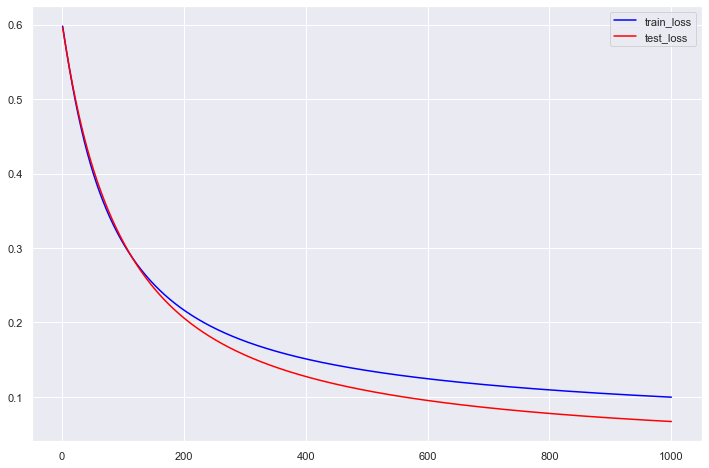

In [13]:
f, ax = plt.subplots(1, 1, figsize=(12, 8)) # type: Figure, Axes
sns.lineplot(x=np.arange(epochs)+1, y=avg_train_losses_per_batch,color="blue", label="train_loss", ax=ax)
sns.lineplot(x=np.arange(epochs)+1, y=avg_test_losses_per_batch, color="red", label="test_loss", ax=ax)


In [14]:
# now calculate accuracy on the test set
with torch.no_grad():
    # train accuracy
    train_pred_probs = model(inputs_train)
    train_pred = torch.round(train_pred_probs)
    train_acc_mask = train_pred == targets_train
    train_acc = (torch.sum(train_acc_mask) / train_acc_mask.shape[0]).item()
    
    # test accuracy
    test_pred_probs = model(inputs_test)
    test_pred = torch.round(test_pred_probs)
    test_acc_mask = test_pred == targets_test
    test_acc = (torch.sum(test_acc_mask) / test_acc_mask.shape[0]).item()
    
    print(f"[INFO] train_acc: {train_acc}  and test_acc: {test_acc}......")



[INFO] train_acc: 0.9824120402336121  and test_acc: 0.9941520690917969......
